In [ ]:
!pip install praat-parselmouth
!pip install --upgrade librosa
!pip install librosa scipy
!pip install datasets
!pip install pysptk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 20.5 MB/s eta 0:00:0

In [ ]:
pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, GlobalAveragePooling2D, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [ ]:
import scipy
from scipy.signal import lfilter #hamming
import pysptk
from scipy.io import wavfile
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Mounted at /content/drive


## Load File

In [ ]:
data = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP/IEMOCAP_MAJOR_LABELLED.csv')

In [ ]:
emotion_counts = data['most_repeated_label'].str.strip().str.lower().value_counts()

# Print unique values along with their counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

frustration: 2026
neutral: 1710
excited: 1174
sadness: 1075
anger: 1042
happiness: 586
surprise: 102
fear: 34
other: 14
disgust: 3


In [ ]:
import pandas as pd

# Modify the labels according to the merging criteria
data['most_repeated_label'] = data['most_repeated_label'].replace({
    'frustration': 'anger',   # Merge 'frustration' into 'anger'
    'excited': 'happy',       # Merge 'excited' into 'happy'
    'happiness': 'happy'      # Merge 'happiness' into 'happy'
})

# Drop rows with the labels: 'surprise', 'fear', 'other', and 'disgust'
data = data[~data['most_repeated_label'].isin(['surprise', 'fear', 'other', 'disgust'])]

# Print updated value counts to verify
print(data['most_repeated_label'].value_counts())

most_repeated_label
anger      3068
happy      1760
neutral    1710
sadness    1075
Name: count, dtype: int64


In [ ]:
len(data)

7613

In [ ]:
audio_features = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/Code/Audio Models/audio_features_with_major_emotion_all_tokens.csv')

In [ ]:
emotion_counts = audio_features['Emotion'].str.strip().str.lower().value_counts()

# Print unique values along with their counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

frustration: 2026
neutral: 1710
excited: 1174
sadness: 1075
anger: 1042
happiness: 586
surprise: 102
fear: 34
other: 14
disgust: 3


In [ ]:
import pandas as pd

# Modify the labels according to the merging criteria
audio_features['Emotion'] = audio_features['Emotion'].replace({
    'frustration': 'anger',   # Merge 'frustration' into 'anger'
    'excited': 'happy',       # Merge 'excited' into 'happy'
    'happiness': 'happy'      # Merge 'happiness' into 'happy'
})

# Drop rows with the labels: 'surprise', 'fear', 'other', and 'disgust'
audio_features = audio_features[~audio_features['Emotion'].isin(['surprise', 'fear', 'other', 'disgust'])]

# Print updated value counts to verify
print(audio_features['Emotion'].value_counts())

Emotion
anger      3068
happy      1760
neutral    1710
sadness    1075
Name: count, dtype: int64


In [ ]:
audio_features.drop(columns=['Emotion', 'Speaker_id'], inplace=True)

In [ ]:
len(audio_features)

7613

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import pandas as pd
import numpy as np

class MultimodalEmotionDataset(Dataset):
    def __init__(self, text_data, audio_data, tokenizer_name='roberta-base', max_length=128):
        # Ensure both datasets are aligned
        assert len(text_data) == len(audio_data), "Text and audio datasets must have same length"

        self.text_data = text_data
        self.audio_features = audio_data.iloc[:, :81].values  # Get first 81 columns as features

        # Convert labels to numerical values
        self.label_map = {'happy': 0, 'neutral': 1, 'anger': 2, 'sadness': 3}
        self.labels = [self.label_map[label] for label in text_data['most_repeated_label']]

        # Initialize tokenizer
        self.tokenizer = RobertaTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        # Get text features
        text = self.text_data['Transcript'].iloc[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Remove the batch dimension added by the tokenizer
        text_features = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

        # Get audio features
        audio_features = torch.FloatTensor(self.audio_features[idx])

        # Get label
        label = torch.tensor(self.labels[idx])

        return {
            'text': text_features,
            'audio': audio_features,
            'label': label
        }

# Create the dataset and data loaders
def create_data_loaders(text_data, audio_data, batch_size=32, train_split=0.7, val_split=0.15):
    # Create dataset
    dataset = MultimodalEmotionDataset(text_data, audio_data)

    # Calculate split sizes
    total_size = len(dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader, test_loader

# Create the data loaders
train_loader, val_loader, test_loader = create_data_loaders(data, audio_features)

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

# Test a batch
sample_batch = next(iter(train_loader))
print("\nSample batch structure:")
print("Text input_ids shape:", sample_batch['text']['input_ids'].shape)
print("Text attention_mask shape:", sample_batch['text']['attention_mask'].shape)
print("Audio features shape:", sample_batch['audio'].shape)
print("Labels shape:", sample_batch['label'].shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Number of batches in train loader: 167
Number of batches in validation loader: 36
Number of batches in test loader: 36

Sample batch structure:
Text input_ids shape: torch.Size([32, 128])
Text attention_mask shape: torch.Size([32, 128])
Audio features shape: torch.Size([32, 81])
Labels shape: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from transformers import RobertaModel

class LateFusion(nn.Module):
    def __init__(self, audio_features=81, num_classes=4):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        hidden_size = self.roberta.config.hidden_size

        # Audio processing
        self.audio_encoder = nn.Sequential(
            nn.Linear(audio_features, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_size)
        )

        # Individual classifiers
        self.text_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        self.audio_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_inputs, audio_features):
        # Process text
        text_outputs = self.roberta(**text_inputs)[0]
        text_feature = torch.mean(text_outputs, dim=1)
        text_logits = self.text_classifier(text_feature)

        # Process audio
        audio_feature = self.audio_encoder(audio_features)
        audio_logits = self.audio_classifier(audio_feature)

        # Late fusion (average logits)
        combined_logits = (text_logits + audio_logits) / 2

        return combined_logits

class HierarchicalAttentionFusion(nn.Module):
    def __init__(self, audio_features=81, num_classes=4):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        hidden_size = self.roberta.config.hidden_size

        # Audio processing
        self.audio_encoder = nn.Sequential(
            nn.Linear(audio_features, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_size)
        )

        # Attention mechanisms
        self.text_attention = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        self.audio_attention = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_inputs, audio_features):
        # Process text
        text_outputs = self.roberta(**text_inputs)[0]

        # Process audio
        audio_encoded = self.audio_encoder(audio_features).unsqueeze(1)

        # Apply attention to text
        text_attention_weights = self.text_attention(text_outputs)
        text_attention_weights = torch.softmax(text_attention_weights, dim=1)
        text_feature = torch.sum(text_outputs * text_attention_weights, dim=1)

        # Apply attention to audio
        audio_attention_weights = self.audio_attention(audio_encoded)
        audio_attention_weights = torch.softmax(audio_attention_weights, dim=1)
        audio_feature = torch.sum(audio_encoded * audio_attention_weights, dim=1)

        # Concatenate and classify
        combined_feature = torch.cat([text_feature, audio_feature], dim=1)
        output = self.classifier(combined_feature)

        return output

class CrossModalTransformerFusion(nn.Module):
    def __init__(self, audio_features=81, num_classes=4):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        hidden_size = self.roberta.config.hidden_size

        # Audio processing
        self.audio_encoder = nn.Sequential(
            nn.Linear(audio_features, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_size)
        )

        # Cross-modal transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_inputs, audio_features):
        # Process text
        text_outputs = self.roberta(**text_inputs)[0]

        # Process audio
        audio_encoded = self.audio_encoder(audio_features).unsqueeze(1)

        # Combine modalities for transformer
        combined_features = torch.cat([text_outputs, audio_encoded], dim=1)

        # Apply transformer
        transformed_features = self.transformer(combined_features)

        # Pool features
        text_feature = transformed_features[:, 0]
        audio_feature = transformed_features[:, -1]

        # Concatenate and classify
        combined_feature = torch.cat([text_feature, audio_feature], dim=1)
        output = self.classifier(combined_feature)

        return output

class GatedMultimodalFusion(nn.Module):
    def __init__(self, audio_features=81, num_classes=4):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        hidden_size = self.roberta.config.hidden_size

        # Audio processing
        self.audio_encoder = nn.Sequential(
            nn.Linear(audio_features, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_size)
        )

        # Gating mechanism
        self.text_gate = nn.Linear(hidden_size, hidden_size)
        self.audio_gate = nn.Linear(hidden_size, hidden_size)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_inputs, audio_features):
        # Process text
        text_outputs = self.roberta(**text_inputs)[0]
        text_feature = torch.mean(text_outputs, dim=1)

        # Process audio
        audio_feature = self.audio_encoder(audio_features)

        # Calculate gates
        text_gate_value = torch.sigmoid(self.text_gate(text_feature))
        audio_gate_value = torch.sigmoid(self.audio_gate(audio_feature))

        # Apply gating and fusion
        fused_feature = (text_gate_value * text_feature + audio_gate_value * audio_feature) / 2

        # Classify
        output = self.classifier(fused_feature)

        return output

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    num_epochs = 15

    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0

        for batch in train_loader:
            text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
            audio_features = batch['audio'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(text_inputs, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
                audio_features = batch['audio'].to(device)
                labels = batch['label'].to(device)

                outputs = model(text_inputs, audio_features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 50)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Testing
    model.eval()
    all_preds = []
    all_labels = []
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_loader:
            text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
            audio_features = batch['audio'].to(device)
            labels = batch['label'].to(device)

            outputs = model(text_inputs, audio_features)
            _, predicted = torch.max(outputs.data, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_total

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Happy', 'Neutral', 'Angry', 'Sad'],
                yticklabels=['Happy', 'Neutral', 'Angry', 'Sad'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nTest Accuracy - {model_name}: {test_accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                              target_names=['Happy', 'Neutral', 'Angry', 'Sad']))

    return test_accuracy, cm



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but sel


Training and Evaluating Late Fusion Model
Epoch 1/15
Training Loss: 4.3615
Validation Loss: 1.0076
Validation Accuracy: 58.11%
--------------------------------------------------
Epoch 2/15
Training Loss: 1.1140
Validation Loss: 0.8866
Validation Accuracy: 65.64%
--------------------------------------------------
Epoch 3/15
Training Loss: 0.7131
Validation Loss: 0.8038
Validation Accuracy: 69.50%
--------------------------------------------------
Epoch 4/15
Training Loss: 0.5744
Validation Loss: 0.7921
Validation Accuracy: 69.41%
--------------------------------------------------
Epoch 5/15
Training Loss: 0.4719
Validation Loss: 0.8395
Validation Accuracy: 68.89%
--------------------------------------------------
Epoch 6/15
Training Loss: 0.4015
Validation Loss: 0.8751
Validation Accuracy: 68.71%
--------------------------------------------------
Epoch 7/15
Training Loss: 0.3453
Validation Loss: 0.9392
Validation Accuracy: 69.94%
--------------------------------------------------
Early

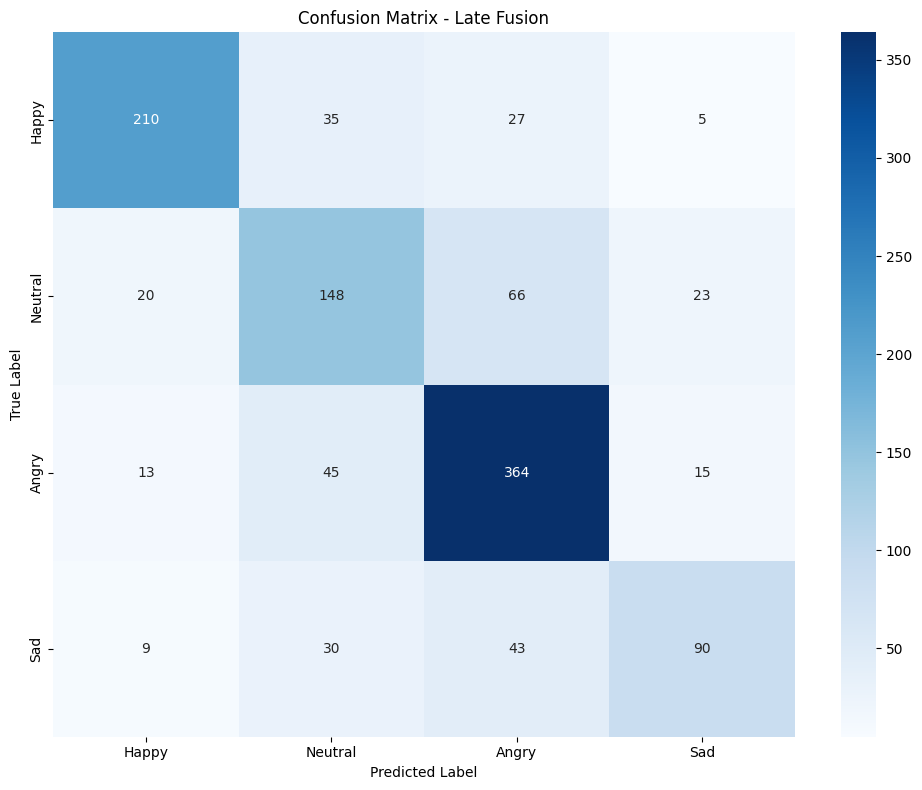

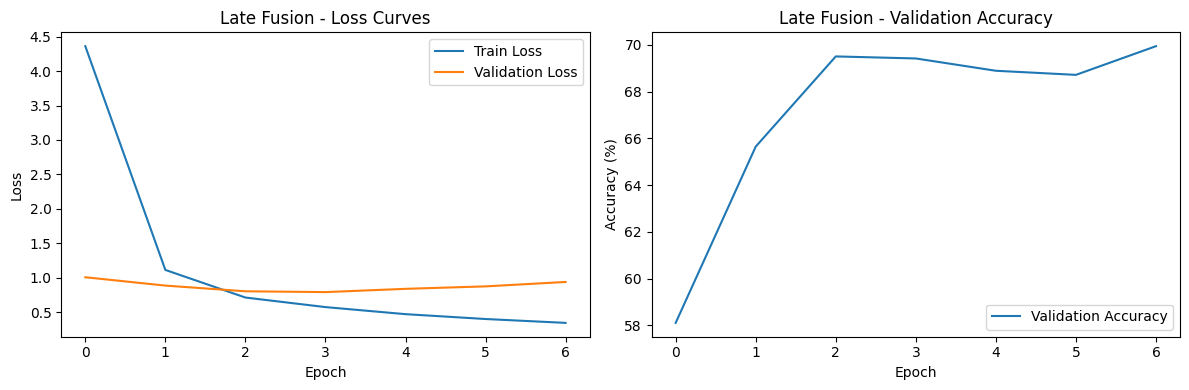


Test Accuracy - Late Fusion: 71.04%

Classification Report:
              precision    recall  f1-score   support

       Happy       0.83      0.76      0.79       277
     Neutral       0.57      0.58      0.57       257
       Angry       0.73      0.83      0.78       437
         Sad       0.68      0.52      0.59       172

    accuracy                           0.71      1143
   macro avg       0.70      0.67      0.68      1143
weighted avg       0.71      0.71      0.71      1143


Training and Evaluating Hierarchical Attention Model
Epoch 1/15
Training Loss: 4.8545
Validation Loss: 1.1064
Validation Accuracy: 58.28%
--------------------------------------------------
Epoch 2/15
Training Loss: 1.1251
Validation Loss: 1.1137
Validation Accuracy: 56.97%
--------------------------------------------------
Epoch 3/15
Training Loss: 0.8758
Validation Loss: 0.9049
Validation Accuracy: 64.15%
--------------------------------------------------
Epoch 4/15
Training Loss: 0.7193
Validatio

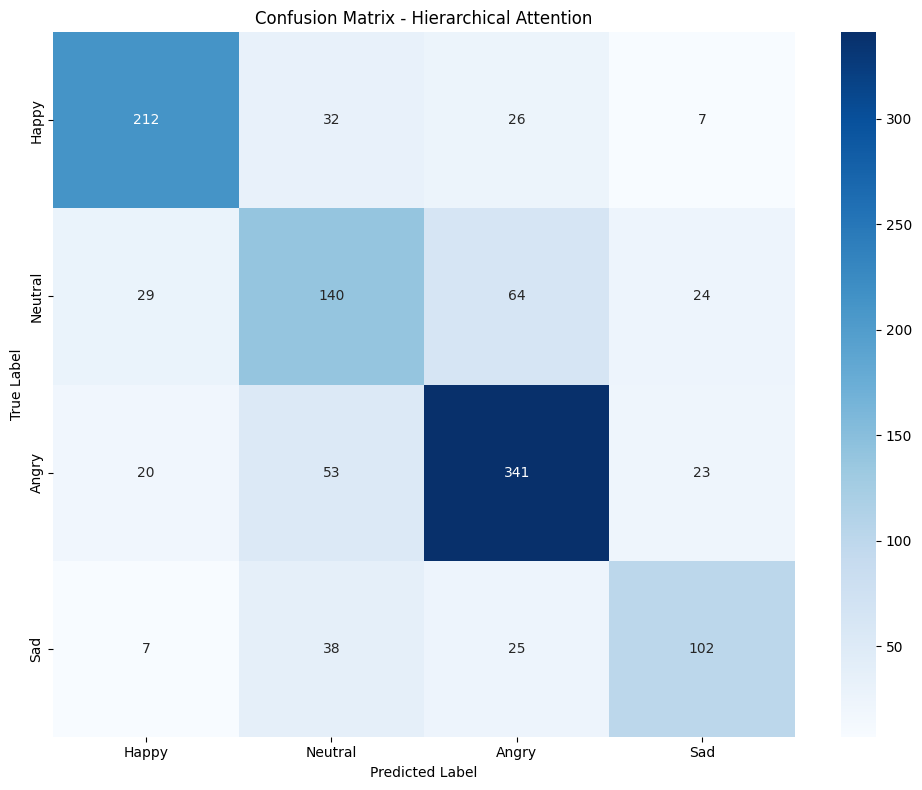

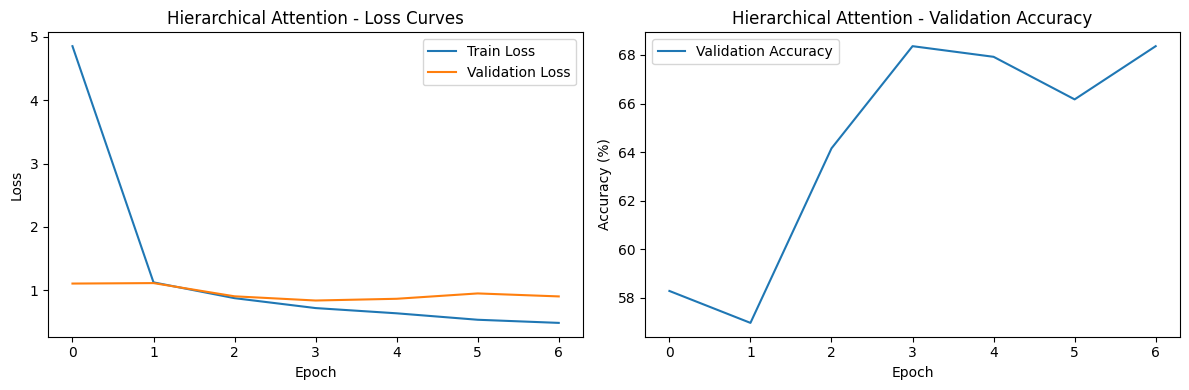


Test Accuracy - Hierarchical Attention: 69.55%

Classification Report:
              precision    recall  f1-score   support

       Happy       0.79      0.77      0.78       277
     Neutral       0.53      0.54      0.54       257
       Angry       0.75      0.78      0.76       437
         Sad       0.65      0.59      0.62       172

    accuracy                           0.70      1143
   macro avg       0.68      0.67      0.68      1143
weighted avg       0.70      0.70      0.70      1143


Training and Evaluating Cross-Modal Transformer Model
Epoch 1/15
Training Loss: 1.1579
Validation Loss: 0.9042
Validation Accuracy: 63.80%
--------------------------------------------------
Epoch 2/15
Training Loss: 0.8172
Validation Loss: 0.8231
Validation Accuracy: 69.33%
--------------------------------------------------
Epoch 3/15
Training Loss: 0.6236
Validation Loss: 0.7988
Validation Accuracy: 69.50%
--------------------------------------------------
Epoch 4/15
Training Loss: 0.50

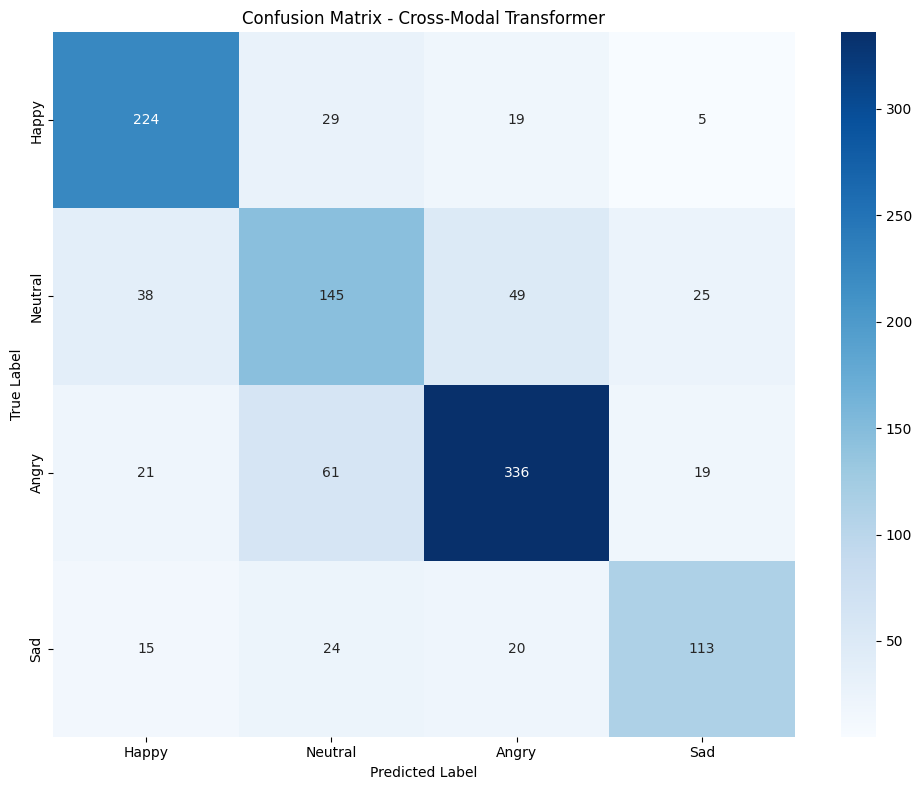

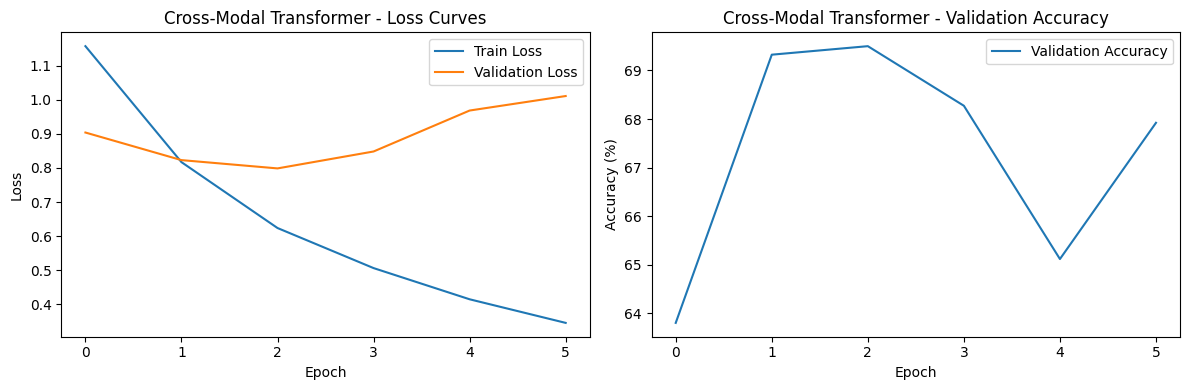


Test Accuracy - Cross-Modal Transformer: 71.57%

Classification Report:
              precision    recall  f1-score   support

       Happy       0.75      0.81      0.78       277
     Neutral       0.56      0.56      0.56       257
       Angry       0.79      0.77      0.78       437
         Sad       0.70      0.66      0.68       172

    accuracy                           0.72      1143
   macro avg       0.70      0.70      0.70      1143
weighted avg       0.72      0.72      0.72      1143


Training and Evaluating Gated Multimodal Model


In [ ]:
# Initialize and train all models
models = {
    'Late Fusion': LateFusion(),
    'Hierarchical Attention': HierarchicalAttentionFusion(),
    'Cross-Modal Transformer': CrossModalTransformerFusion(),
    'Gated Multimodal': GatedMultimodalFusion()
}

results = {}
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training and Evaluating {name} Model")
    print('='*50)

    accuracy, conf_matrix = train_and_evaluate_model(
        model, train_loader, val_loader, test_loader, name
    )
    results[name] = {'accuracy': accuracy, 'confusion_matrix': conf_matrix}

# Compare accuracies with bar plot
plt.figure(figsize=(12, 6))
accuracies = [results[model]['accuracy'] for model in models.keys()]
plt.bar(models.keys(), accuracies)
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final comparison summary
print("\nFinal Model Comparison Summary:")
print("-"*50)
for name in models.keys():
    print(f"{name}:")
    print(f"Test Accuracy: {results[name]['accuracy']:.2f}%")
    print("-"*50)